In [9]:
from pathlib import Path

import xarray as xr
import emaremes as mrms
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = mrms.download.timerange(
    pd.Timestamp("2021-06-26"),
    pd.Timestamp("2021-06-27"),
    frequency=pd.Timedelta(minutes=30),
    verbose=True,
)

# files = (mrms.download.LOCALPATH / "20210627").glob("PrecipRate*.grib2.gz")
# files = sorted(files)

print(f"{len(files)} files found")

Nothing new to download :D
49 files found


In [3]:
lil_cal = gpd.read_file("../data_old/Subcatchments__WestLittleCal/Subcatchments__WestLittleCal.shp")
lil_cal.explore(column="Id", categorical=True)

In [4]:
lil_cal["geometry"] = lil_cal["geometry"].buffer(0.05)
blob = lil_cal.dissolve().simplify(tolerance=10)
blob.explore()

In [5]:
# Extract Polygon from GeoSeries and translate to GRIB coordinates
geo_blob = blob.to_crs("4326")
translated = geo_blob.translate(xoff=360)

# Set a extent to make a clip of the GRIB data before masking
bounds = geo_blob.bounds
extent = mrms.utils.Extent((bounds.miny[0], bounds.maxy[0]), (bounds.minx[0], bounds.maxx[0]))

In [27]:
@mrms.utils.unzip_if_gz
def load(file: Path) -> xr.Dataset:
    return xr.load_dataset(file, engine="cfgrib", decode_timedelta=False)


@mrms.utils.unzip_if_gz
def extract_data(file: Path) -> np.ndarray:
    with xr.load_dataset(file, engine="cfgrib", decode_timedelta=False) as ds:
        clip = ds.loc[extent.as_xr_slice()]
        data = clip["unknown"].values.copy()

    return data

In [35]:
ds = load(files[25])
clip = ds.loc[extent.as_xr_slice()]

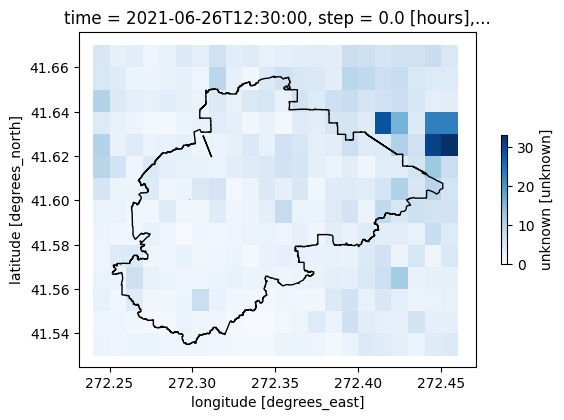

In [41]:
fig, ax = plt.subplots()
clip["unknown"].plot(ax=ax, vmin=0, zorder=1, cmap="Blues", cbar_kwargs=dict(shrink=0.35))
translated.plot(ax=ax, zorder=2, ec="k", fc="none")
ax.set_ylim(extent.down_lat - 0.01, extent.up_lat + 0.02)
ax.set_xlim(360 + extent.left_lon - 0.02, 360 + extent.right_lon + 0.02)
plt.show()

In [32]:
lon, lat = clip.longitude, clip.latitude
lx, ly = np.meshgrid(lon, lat)
lones = np.ones_like(lx)

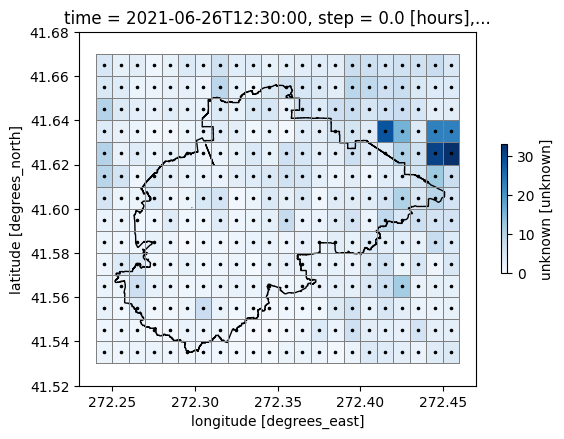

In [ ]:
fig, ax = plt.subplots()
clip["unknown"].plot(ax=ax, vmin=0, zorder=1, cmap="Blues", cbar_kwargs=dict(shrink=0.35))
translated.plot(ax=ax, zorder=2, ec="k", fc="none")
ax.pcolormesh(lx, ly, lones, fc="none", ec="gray", lw=0.5, zorder=3)
ax.scatter(lx, ly, s=10, marker=".", c="k", zorder=4)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.set_xlim(xlim[0] - 0.01, xlim[1] + 0.01)
ax.set_ylim(ylim[0] - 0.01, ylim[1] + 0.01)

plt.show()

In [52]:
arrs = np.stack([extract_data(f) for f in files], axis=-1)
assert arrs.shape == (14, 22, 49)


In [53]:
from multiprocessing import Pool

In [54]:
with Pool() as pool:
    _ar = pool.map(extract_data, files)

arrs = np.stack(_ar, axis=-1)

In [55]:
assert arrs.shape == (14, 22, 49)
